In [81]:
from pathlib import Path
from datetime import datetime, timedelta
from functools import reduce
from operator import add

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from  matplotlib.colors import LinearSegmentedColormap, TwoSlopeNorm
import matplotlib.dates as mdates

from music_league_graphs.scraper import create_dataframe
from music_league_graphs.spotify_api import SpotifyAPI

In [82]:
df, names = create_dataframe(Path("../league_rounds/"))

df["round_score"] = df[names].sum(axis=1)
df["round_rank"] = df.groupby("round")["round_score"].rank(ascending=False).astype(int)


If you want to convert the music league user names to real names create a translator dictionary like the one below. Otherwise set translator to `None`, or just delete the block below

In [83]:

translator = {
    "Sacha Darwin": "Sacha",
    "Bethany Dickens-Devereux": "Bethany",
    "sam24ahhhhhh": "Sam",
    "Martha Mukungurutse": "Martha",
    "Victoria Whitehead": "Victoria",
    "Andrej Zacharenkov": "Andrej",
    "fred": "Fred",
    "Jenny": "Jenny B",
    "Tim            :)": "Tim P",
    "Mel Shallcrass": "Mel",
    "Jamie England": "Jamie",
    "Helen Adams": "Helen",
    "Rory": "Rory",
    "murraypurves101": "Murray",
    "James Hardwick": "James",
    "Olek": "Olek",
    "Russell": "Russell",
    "owainst": "Owain",
    "Tim": "Tim C",
    "Figataur": "Mark",
    "Jenny Seaborne": "Jenny S",
    "diplodocus.17": "Harry",
    "Sowdagar": "Sow",
    "[Left the league]": "[Left the league]",
    "Peter Rowe": "Peter R",
}

if translator is not None:
        df = df.replace(translator)
        df = df.rename(mapper=translator, axis=1)
        names = list(set(translator.values()).intersection(set(df.keys())))

In [84]:
try:
    api = SpotifyAPI()
    api.get_data(df["song_id"])
    spotify_data = api.df
    df = pd.concat((df, spotify_data), axis=1)
except RuntimeError:
    print("Couldn't access spotify API")
    raise

/home/ferd/music-league-graphs/.venv/lib/python3.11/site-packages/numpy/_core/fromnumeric.py:57: FutureWarning: 'Series.swapaxes' is deprecated and will be removed in a future version. Please use 'Series.transpose' instead.
  return bound(*args, **kwds)


Simply sorting the dataframe won't resolve ties correctly. The below one does

In [85]:
def resolve_podium(df) -> list[str]:
    """
    Resolve the winning order in case of draws in points. Resolution order is:
    1. Largest total positive votes
    2. Lowest number of down votes (not)
    """
    rankings = df.groupby("submitter")["round_score"].sum().rank(ascending=False).astype(int).sort_values()
    winning_order: list[str] = []

    rank = 1

    while rank != len(rankings) + 1:
        if len(rankings[rankings == rank]) > 1:
            tied_names = rankings[rankings == rank].index
            tie_break_df = df[df["submitter"].isin(tied_names)]
            tie_break_df.loc[:, names] = tie_break_df[names].map(lambda x: x if x > 0 else 0) # remove all downvotes
            positive_votes =  tie_break_df.groupby("submitter")[names].sum().sum(axis=1).sort_values()
            if len(set(positive_votes)) < len(positive_votes):
                print("Tie break unresolved, alphabetical order used")
            order = [k for k, _ in sorted(positive_votes.to_dict().items(), key=lambda item: item[1], reverse=True)]
            winning_order += order
            rank += len(order)
        else:
            winning_order.append((rankings[rankings==rank]).index[0])
            rank += 1
        if len(winning_order) == len(rankings):
            break
    return winning_order

winning_order = resolve_podium(df)


## Round Winners

Below we list all of the winners for each round

In [86]:
for round_name, scores in df.groupby("round"):
    winning_score = scores["round_score"].max()
    a = f"Round     | {round_name}"
    print(a + "\n" + '-'*len(a))
    for _, row in scores[scores["round_score"] == winning_score][["submitter", "song_name", "round_score"]].iterrows():
        print(f"{row['submitter']:10} | {row['song_name']:40} | {int(row['round_score'])}")
    print()


Round     | 120 seconds to go ⏱
-------------------------------
Mel        | Fell In Love With a Girl                 | 21

Round     | Cover🎪
------------------
Jamie      | Hurt                                     | 23

Round     | Eurovision💶👀
------------------------
Rory       | SHUM                                     | 20

Round     | Film Soundtrack 🎞
-----------------------------
Jamie      | Lose Yourself                            | 23

Round     | Generation Game 👶
-----------------------------
Sacha      | Message In A Bottle                      | 16
Bethany    | Gypsy Woman (La Da Dee La Da Da)         | 16

Round     | Ich spreche kein Englisch 👽
---------------------------------------
murray     | Mundian to Bach Ke                       | 29

Round     | Remix 🔀
-------------------
murray     | 19-2000 - Soulchild Remix                | 19
Martha     | Flowers - Sunship Remix                  | 19

Round     | Songs to code to 👩‍💻
--------------------------------
Jenn

### Highest and lowest scores across the league's rounds

In [87]:
# highest
df.sort_values("round_score", ascending=False).iloc[:10][["round", "submitter", "song_name", "round_score"]]

,round,submitter,song_name,round_score
94,Ich spreche kein Englisch 👽,murray,Mundian to Bach Ke,29.0
57,Film Soundtrack 🎞,Jamie,Lose Yourself,23.0
19,Cover🎪,Jamie,Hurt,23.0
58,Film Soundtrack 🎞,Martha,9 to 5,21.0
0,120 seconds to go ⏱,Mel,Fell In Love With a Girl,21.0
38,Eurovision💶👀,Rory,SHUM,20.0
113,Remix 🔀,murray,19-2000 - Soulchild Remix,19.0
149,Wish you were here 🌍,Mel,London Calling - Remastered,19.0
114,Remix 🔀,Martha,Flowers - Sunship Remix,19.0
20,Cover🎪,Bethany,Killing Me Softly With His Song,18.0


In [88]:
# lowest
df.sort_values("round_score", ascending=True).iloc[:10][["round", "submitter", "song_name", "round_score"]]

,round,submitter,song_name,round_score
18,120 seconds to go ⏱,Andrej,Baby Shark,-17.0
74,Film Soundtrack 🎞,Olek,Waters of Nazareth x We Are your Friends x Pha...,-13.0
37,Cover🎪,James,Bohemian Rhapsody,-11.0
56,Eurovision💶👀,Russell,Congratulations,-10.0
112,Ich spreche kein Englisch 👽,Andrej,Dragostea Din Tei,-10.0
36,Cover🎪,Sacha,Painkiller,-7.0
73,Film Soundtrack 🎞,Andrej,"Come What May - From ""Moulin Rouge"" Soundtrack",-5.0
111,Ich spreche kein Englisch 👽,Tim P,Tequila,-5.0
166,Wish you were here 🌍,Bethany,Atlantic City,-5.0
148,Songs to code to 👩‍💻,Olek,Final - Live Version - Rappel,-5.0


## Voting Matrix

The voting matrix shows the cumlative votes given between every player across all of the rounds.

In [89]:
# arr has shape (num_rounds, num_competitors, num_competitors)
# Any missing values are filled with 0.0

arr: list[np.ndarray] = []
for _, a in df.set_index("submitter").groupby("round")[winning_order]:
    a = a.reindex(winning_order).fillna(0).to_numpy()
    arr.append(a[None, :, :])

arr = np.concat(arr)
voting_matrix = np.sum(arr, axis=0)

Rows are the points received, columns the points given. The rows and columns are sorted into the final order of the league

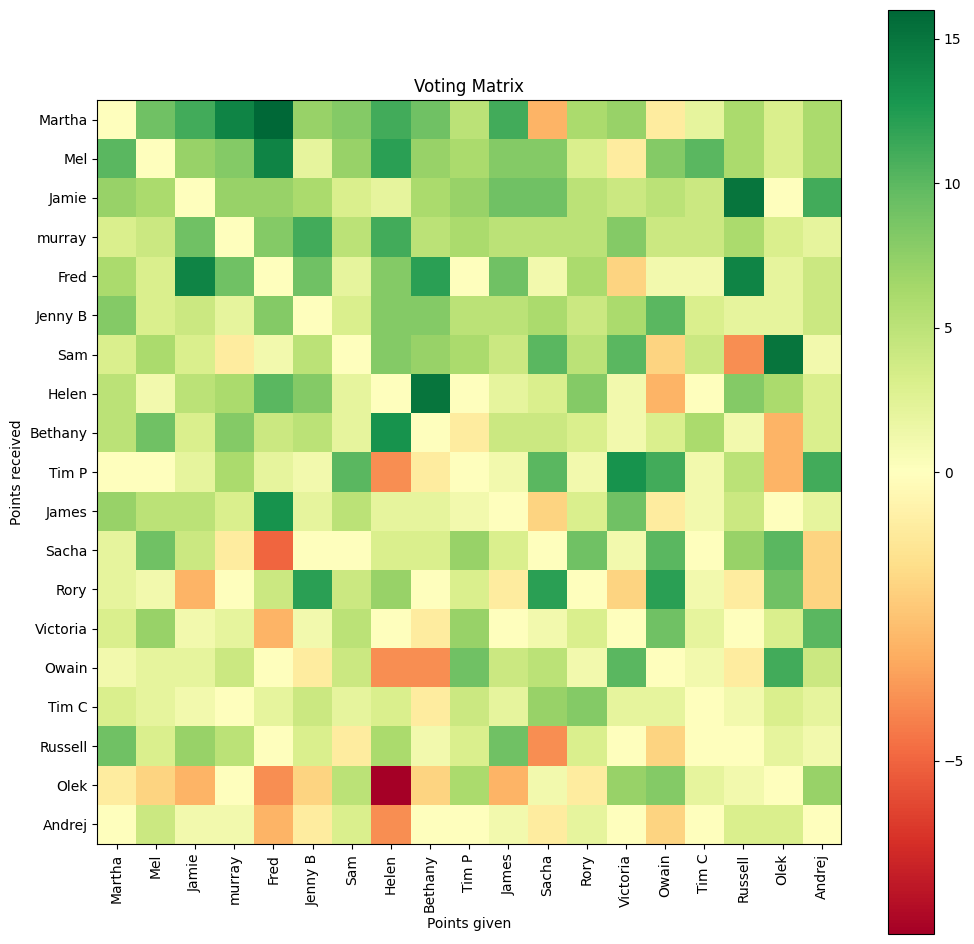

In [90]:
fig, ax = plt.subplots(figsize=(12,12))

cmap=LinearSegmentedColormap.from_list('rg',["r", "w", "g"], N=256)
norm = TwoSlopeNorm(vmin=np.min(voting_matrix),
                        vcenter=0,
                        vmax=np.max(voting_matrix))

plt.imshow(voting_matrix, cmap='RdYlGn', norm=norm, interpolation='nearest')
plt.xticks(np.arange(len(winning_order)), winning_order, rotation='vertical')
plt.yticks(np.arange(len(winning_order)), winning_order)
plt.xlabel("Points given")
plt.ylabel("Points received")
plt.title("Voting Matrix")


cbar = plt.colorbar()

plt.show()

In [91]:
# Biggest differences 

reciprocals = np.abs((np.triu(voting_matrix) - np.tril(voting_matrix).T))
diffs = np.unravel_index(np.argsort(reciprocals.reshape(-1))[::-1][:10], reciprocals.shape)

for row, col in zip(*diffs):
    print(f"{winning_order[col]} for {winning_order[row]}: {int(voting_matrix[row, col])}")

Russell for Fred: 14
Olek for Helen: 6
Fred for Mel: 14
Helen for Mel: 12
Owain for Jenny B: 10
murray for Martha: 14
Andrej for Tim P: 11
Russell for Sacha: 7
Owain for Rory: 12
Andrej for Victoria: 10


### Biggest Stans and biggest haters

In [92]:
biggest_haters = np.unravel_index(np.argsort(voting_matrix.reshape(-1))[::-1][:10], voting_matrix.shape)
for row, col in zip(*biggest_haters):
    print(f"{winning_order[col]} for {winning_order[row]}: {int(voting_matrix[row, col])}")

Fred for Martha: 16
Olek for Sam: 15
Russell for Jamie: 15
Bethany for Helen: 15
Russell for Fred: 14
murray for Martha: 14
Jamie for Fred: 14
Fred for Mel: 14
Fred for James: 13
Helen for Bethany: 13


In [93]:
biggest_haters = np.unravel_index(np.argsort(voting_matrix.reshape(-1))[:10], voting_matrix.shape)
for row, col in zip(*biggest_haters):
    print(f"{winning_order[col]} for {winning_order[row]}: {int(voting_matrix[row, col])}")

Helen for Olek: -8
Fred for Sacha: -5
Sacha for Russell: -4
Fred for Olek: -4
Bethany for Owain: -4
Helen for Tim P: -4
Helen for Owain: -4
Russell for Sam: -4
Helen for Andrej: -4
James for Olek: -3


## Voting Correlation

This shows who votes similarly, and who doesn't. Note that the matrix is symmetrical

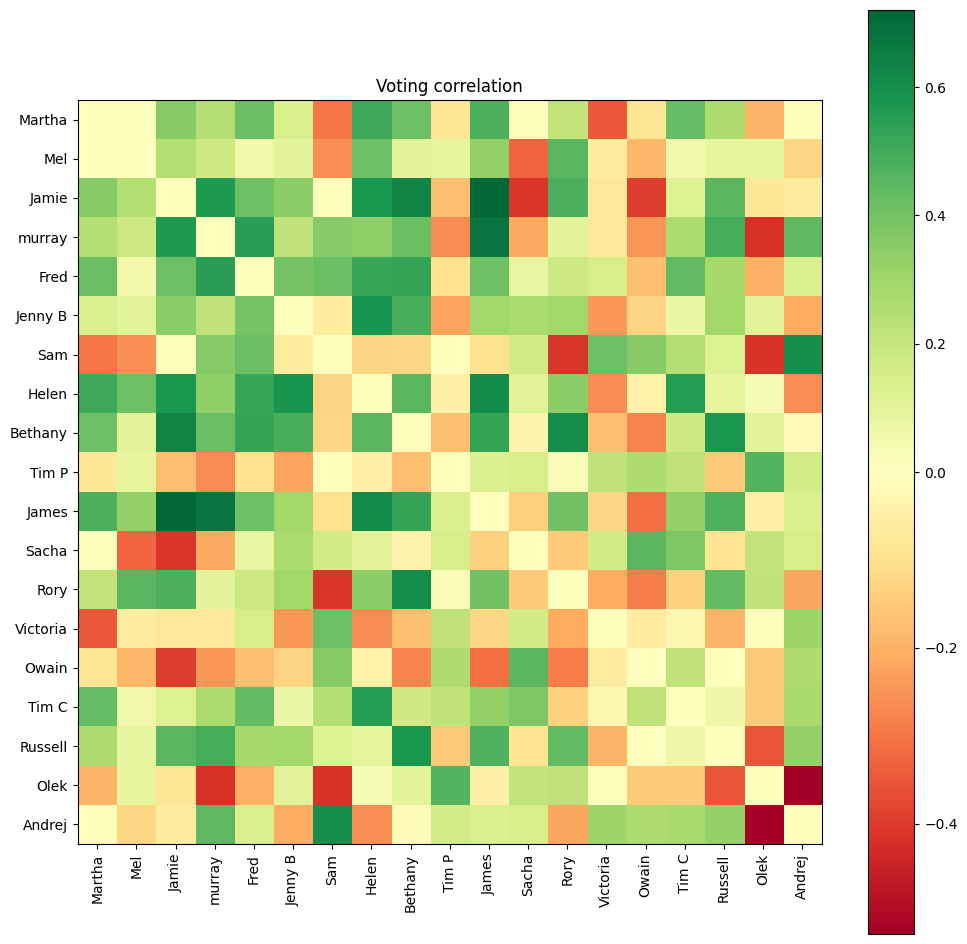

In [94]:
# Sort arr into an array that's lists of each competitors votes per round

voting_correlation = np.corrcoef(np.vstack(voting_matrix).T)
np.fill_diagonal(voting_correlation, 0.0)

fig, ax = plt.subplots(figsize=(12,12))

cmap=LinearSegmentedColormap.from_list('rg',["r", "w", "g"], N=256)
norm = TwoSlopeNorm(vmin=np.min(voting_correlation),
                        vcenter=0,
                        vmax=np.max(voting_correlation))

plt.imshow(voting_correlation, cmap='RdYlGn', norm=norm, interpolation='nearest')
plt.xticks(np.arange(len(winning_order)), winning_order, rotation='vertical')
plt.yticks(np.arange(len(winning_order)), winning_order)
plt.title("Voting correlation")


cbar = plt.colorbar()

plt.show()

### Most and least voting-correlated

In [95]:
most_correlated = np.unravel_index(np.argsort(-voting_correlation.reshape(-1))[:20:2], voting_matrix.shape)
for row, col in zip(*most_correlated):
    print(f"{winning_order[col]} and {winning_order[row]}: {voting_correlation[row, col]:.2f}")

James and Jamie: 0.72
murray and James: 0.68
Bethany and Jamie: 0.63
Helen and James: 0.61
Rory and Bethany: 0.60
Andrej and Sam: 0.60
Helen and Jenny B: 0.58
Bethany and Russell: 0.58
Helen and Jamie: 0.57
murray and Jamie: 0.56


In [96]:
least_correlated = np.unravel_index(np.argsort(voting_correlation.reshape(-1))[:20:2], voting_matrix.shape)
for row, col in zip(*least_correlated):
    print(f"{winning_order[col]} and {winning_order[row]}: {voting_correlation[row, col]:.2f}")

Olek and Andrej: -0.53
Olek and murray: -0.42
Olek and Sam: -0.41
Sacha and Jamie: -0.41
Rory and Sam: -0.41
Owain and Jamie: -0.40
Olek and Russell: -0.35
Victoria and Martha: -0.35
Sacha and Mel: -0.33
James and Owain: -0.31


## Genre Correlation

See who submitted similar genres. Note that Spotify's list of genres is pretty wild, so this is pretty rough

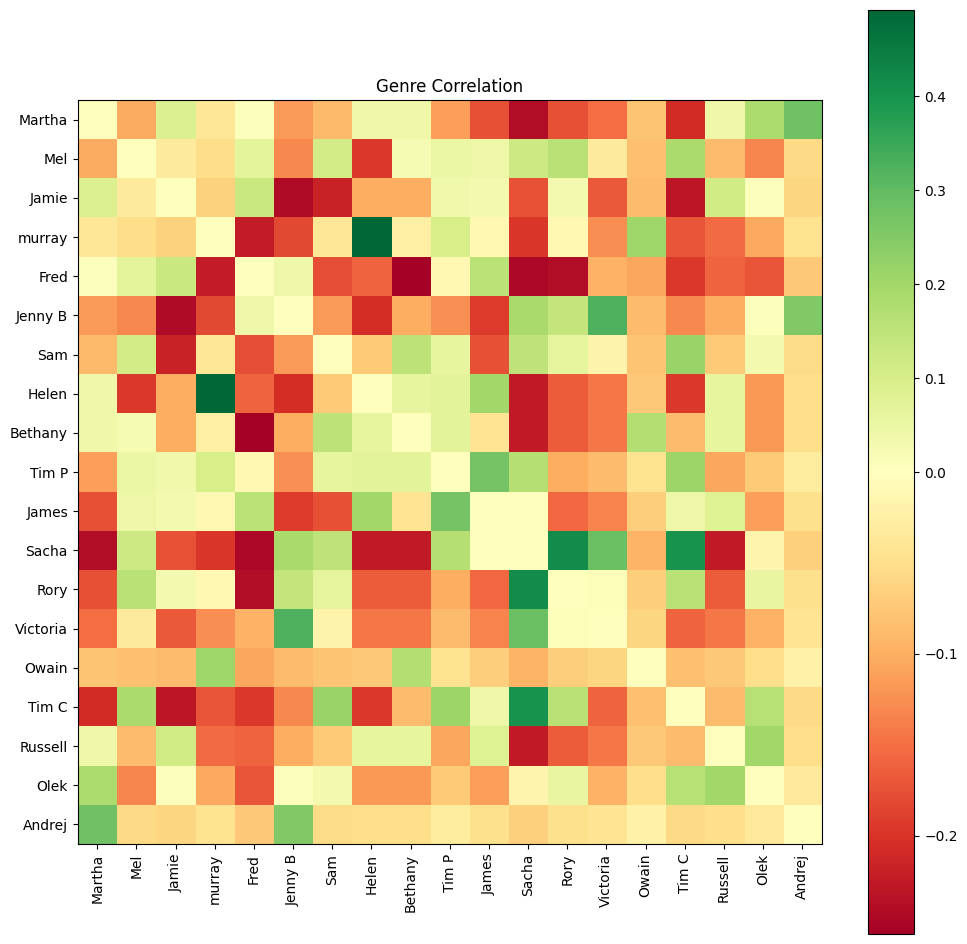

In [97]:
unique_genres = set()

for submitter in winning_order:
    rest = set(reduce(add, df[df.submitter != submitter]["genres"].values))
    unique_genres |= set(reduce(add, df[df.submitter == submitter]["genres"])).difference(rest)

all_genres = list({genre for genres in df.genres for genre in genres}.difference(unique_genres))

x = df.groupby("submitter")["genres"].apply(lambda x: reduce(add, x)).reindex(winning_order).map(set)

genre_matrix = np.zeros((len(winning_order), len(all_genres)))

for i, genres in enumerate(x.values):
    for j, genre in enumerate(all_genres):
        if genre in genres:
            genre_matrix[i][j] = 1.0

voting_matrix = np.corrcoef(genre_matrix)
np.fill_diagonal(voting_matrix, 0.0)

fig, ax = plt.subplots(figsize=(12,12))

cmap=LinearSegmentedColormap.from_list('rg',["r", "w", "g"], N=256)
norm = TwoSlopeNorm(vmin=np.min(voting_matrix),
                        vcenter=0,
                        vmax=np.max(voting_matrix))

plt.imshow(voting_matrix, cmap='RdYlGn', norm=norm, interpolation='nearest')
plt.xticks(np.arange(len(winning_order)), winning_order, rotation='vertical')
plt.yticks(np.arange(len(winning_order)), winning_order)
plt.title("Genre Correlation")


cbar = plt.colorbar()

plt.show()

### Most and least genre correlated

In [98]:
most_genre_correlated = np.unravel_index(np.argsort(-voting_matrix.reshape(-1))[:20:2], voting_matrix.shape)
for row, col in zip(*most_genre_correlated):
    print(f"{winning_order[col]} and {winning_order[row]}: {voting_matrix[row, col]:.2f}")

Helen and murray: 0.49
Rory and Sacha: 0.42
Sacha and Tim C: 0.40
Victoria and Jenny B: 0.33
Victoria and Sacha: 0.28
Andrej and Martha: 0.28
Tim P and James: 0.27
Andrej and Jenny B: 0.25
Tim C and Sam: 0.21
Tim C and Tim P: 0.21


In [99]:
least_genre_correlated = np.unravel_index(np.argsort(voting_matrix.reshape(-1))[:20:2], voting_matrix.shape)
for row, col in zip(*least_genre_correlated):
    print(f"{winning_order[col]} and {winning_order[row]}: {voting_matrix[row, col]:.2f}")

Bethany and Fred: -0.25
Fred and Sacha: -0.24
Jamie and Jenny B: -0.24
Rory and Fred: -0.24
Sacha and Martha: -0.24
Tim C and Jamie: -0.23
Bethany and Sacha: -0.22
Russell and Sacha: -0.22
Helen and Sacha: -0.22
Fred and murray: -0.22


## Average positive vote given out

Look at who chunks their votes into lumps vs those who scatter their votes like chicken feed

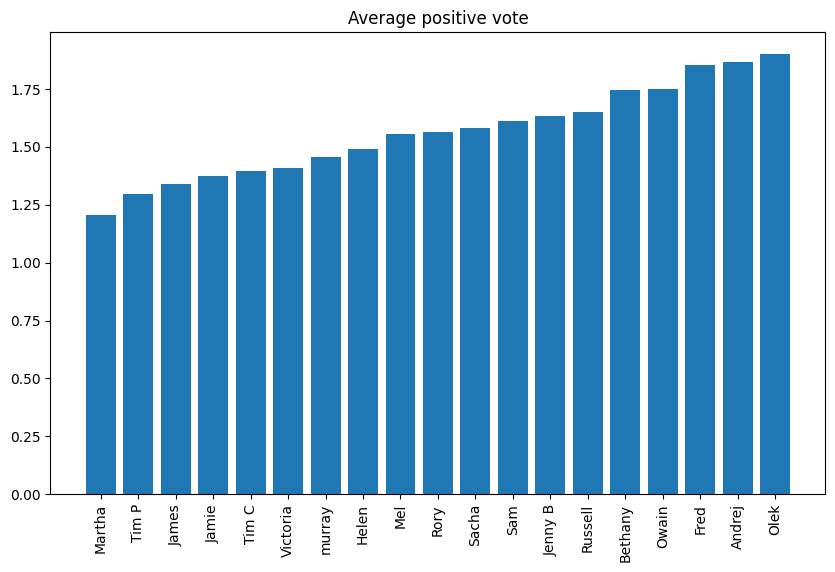

In [100]:
x = arr.reshape(-1, len(winning_order))
x[x <= 0.0] = np.nan
a = np.nanmean(x, axis=0)

fig, ax = plt.subplots(figsize=(10, 6))

ax.set_title("Average positive vote")

ax.bar(np.arange(len(winning_order)), a[np.argsort(a)])
ax.set_xticks(np.arange(len(winning_order)), labels=[winning_order[i] for i in np.argsort(a)], rotation="vertical")

plt.show()

## Average song age

Plot every players average song age with respect to today (or when this notebook was run). Note that the accuracy of date on some songs is worse than others (year vs month vs day, so this isn't 100% accurate)

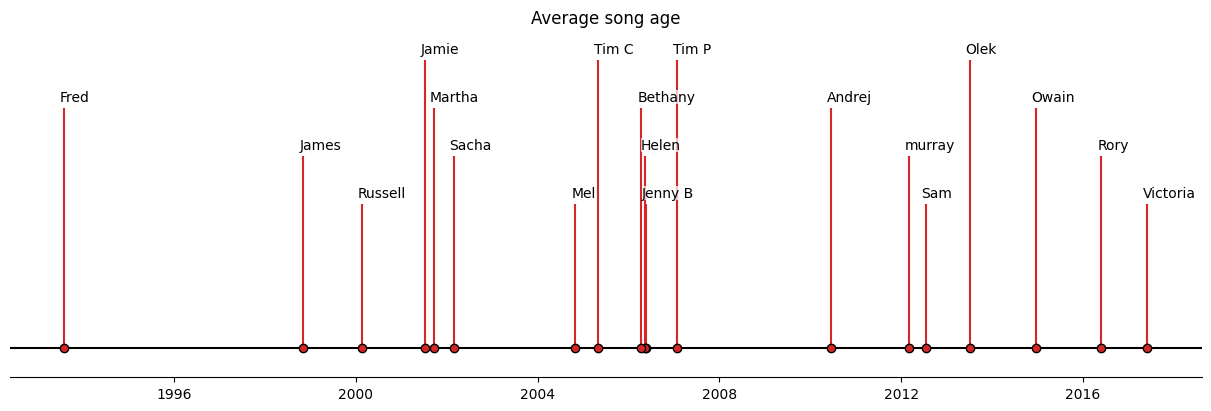

In [101]:
df["song_age_seconds"] = (datetime.now() - df["release_date"]).dt.total_seconds()
ages = df.groupby("submitter")["song_age_seconds"].mean().sort_values().map(lambda x: datetime.now() - timedelta(seconds=x))

fig, ax = plt.subplots(figsize=(12, 4), layout="constrained")
ax.set(title="Average song age")

levels = [(i % 4) / 3 + 1 for i in range(len(ages))]

# The vertical stems.
ax.vlines(ages, 0, levels,
          color=[("tab:red", 1)
                 for _ in ages])
# The baseline.
ax.axhline(0, c="black")
# The markers on the baseline
ax.plot(ages, np.zeros_like(ages), "ko", mfc="tab:red")

# Annotate the lines.
for date, level, name in zip(ages, levels, ages.index):
    ax.annotate(name, xy=(date, level),
                xytext=(-3, np.sign(level)*3), textcoords="offset points",
                verticalalignment="bottom" if level > 0 else "top",
                bbox=dict(boxstyle='square', pad=0, lw=0, fc=(1, 1, 1, 0.7)))

ax.yaxis.set(major_locator=mdates.YearLocator(),
             major_formatter=mdates.DateFormatter("%Y"))

# Remove the y-axis and some spines.
ax.yaxis.set_visible(False)
ax.spines[["left", "top", "right"]].set_visible(False)

ax.margins(y=0.1)
plt.show()

In [102]:
oldest = df.groupby("submitter")["song_age_seconds"].max().apply(lambda x: datetime.now() - timedelta(seconds=x)).sort_values()
youngest = df.groupby("submitter")["song_age_seconds"].min().apply(lambda x: datetime.now() - timedelta(seconds=x)).sort_values()

oldest_oldest = df.iloc[df[df["submitter"] == oldest.index[0]]["song_age_seconds"].idxmax()][["submitter", "release_date", "song_name"]]
youngest_oldest = df.iloc[df[df["submitter"] == oldest.index[-1]]["song_age_seconds"].idxmax()][["submitter", "release_date", "song_name"]]
youngest_youngest = df.iloc[df[df["submitter"] == youngest.index[-1]]["song_age_seconds"].idxmin()][["submitter", "release_date", "song_name"]]
oldest_youngest = df.iloc[df[df["submitter"] == youngest.index[0]]["song_age_seconds"].idxmin()][["submitter", "release_date", "song_name"]]

print(oldest_youngest.to_list())


['Sacha', Timestamp('2023-01-20 00:00:00'), 'Austerity']


In [103]:
# does song age correlate with overall position

np.corrcoef(np.c_[ages.reindex(winning_order).argsort(), np.arange(len(ages))].T)

array([[1.        , 0.36315789],
       [0.36315789, 1.        ]])

### Mean song length

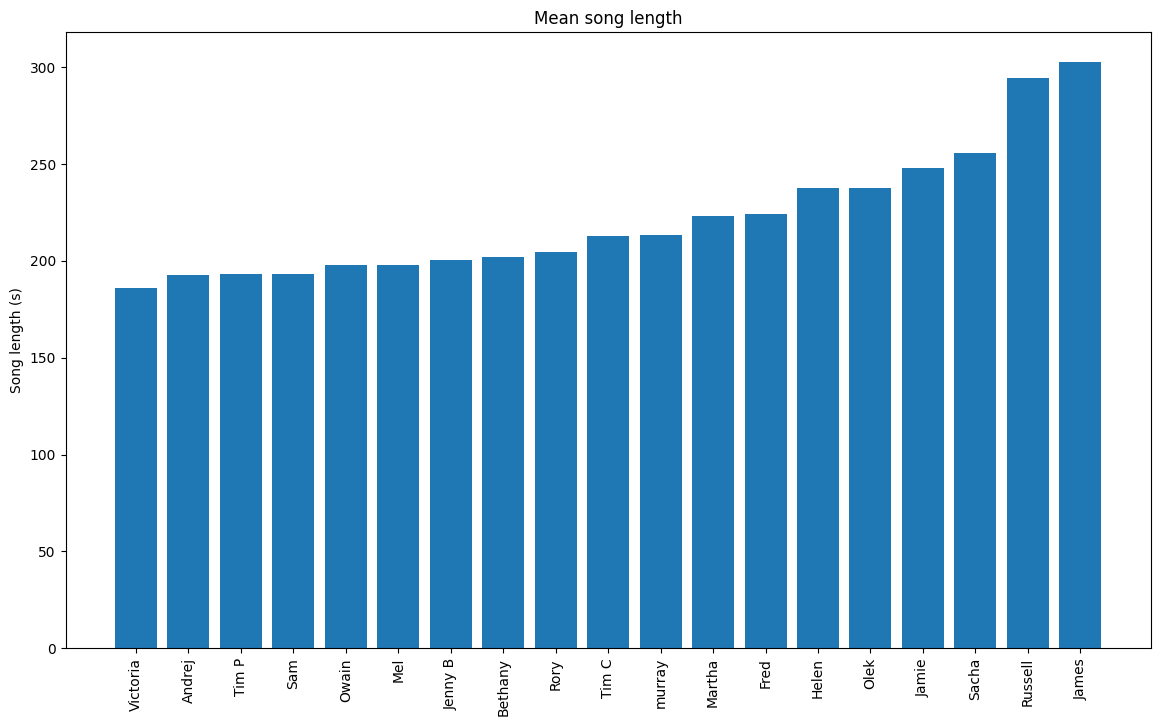

In [104]:
lengths = df.groupby("submitter")["duration_s"].mean().sort_values()

fig, ax = plt.subplots(figsize=(14, 8))

ax.bar(np.arange(len(lengths)), lengths)
ax.set_xticks(np.arange(len(winning_order)), lengths.index, rotation='vertical')
ax.set_title("Mean song length")
ax.set_ylabel("Song length (s)")
plt.show()

In [105]:
# Correlation between mean song length and overall league rank
np.corrcoef(lengths.reindex(winning_order).rank(), np.arange(1, len(winning_order)+1))


array([[ 1.        , -0.07368421],
       [-0.07368421,  1.        ]])

### Longest and shortest songs

In [106]:
df.sort_values("duration_s", ascending=False)[["submitter", "song_name", "duration_s"]].iloc[:10]

,submitter,song_name,duration_s
143,Russell,Blue Room,1053.813
145,James,Never Gonna Reach Me - Hot Toddy Remix,580.363
136,Sacha,Exercises in Futility V,495.626
123,Jamie,"Girls & Boys - Pet Shop Boys Remix, 2012 Remaster",436.546
93,Tim C,Seek & Destroy - Remastered,414.720
120,James,"Relight My Fire - 12"" Disco Remix",406.213
74,Olek,Waters of Nazareth x We Are your Friends x Pha...,391.782
117,Helen,Heads Will Roll - A-Trak Remix,383.893
27,murray,War Pigs,379.647
174,James,Satisfy My Soul,362.956


In [107]:
df.sort_values("duration_s", ascending=True)[["submitter", "song_name", "duration_s"]].iloc[:10]

,submitter,song_name,duration_s
9,Tim C,Short Attention Span,8.888
15,Rory,Girl Fight,15.472
147,Victoria,Baby Park,55.500
18,Andrej,Baby Shark,80.927
8,Victoria,say goodbye,86.749
7,Owain,Sacabambapis,91.384
1,Jamie,Golden Slumbers - Remastered 2009,91.760
5,Martha,Mother Nature's Bitch,93.737
14,Fred,Cripple Creek Ferry,93.960
16,Bethany,Degradation,94.506


## Rankings if only downvotes/upvotes counted

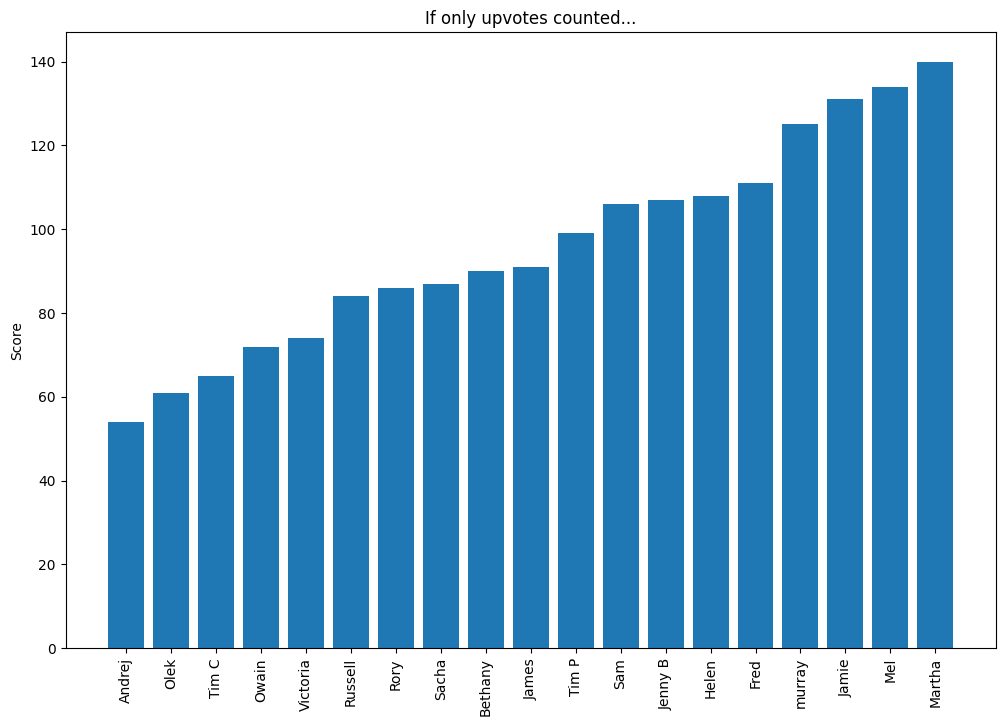

In [108]:
positive_votes = np.where(arr > 0, arr, 0)

positive_scores = np.sum(positive_votes, axis=(0, 2))

order = np.argsort(positive_scores)

fig, ax = plt.subplots(figsize=(12, 8))

ax.bar(np.arange(len(winning_order)), np.sort(positive_scores))
ax.set_xticks(range(len(winning_order)), [winning_order[i] for i in order], rotation="vertical")
ax.set_ylabel("Score")
ax.set_title("If only upvotes counted...")

plt.show()

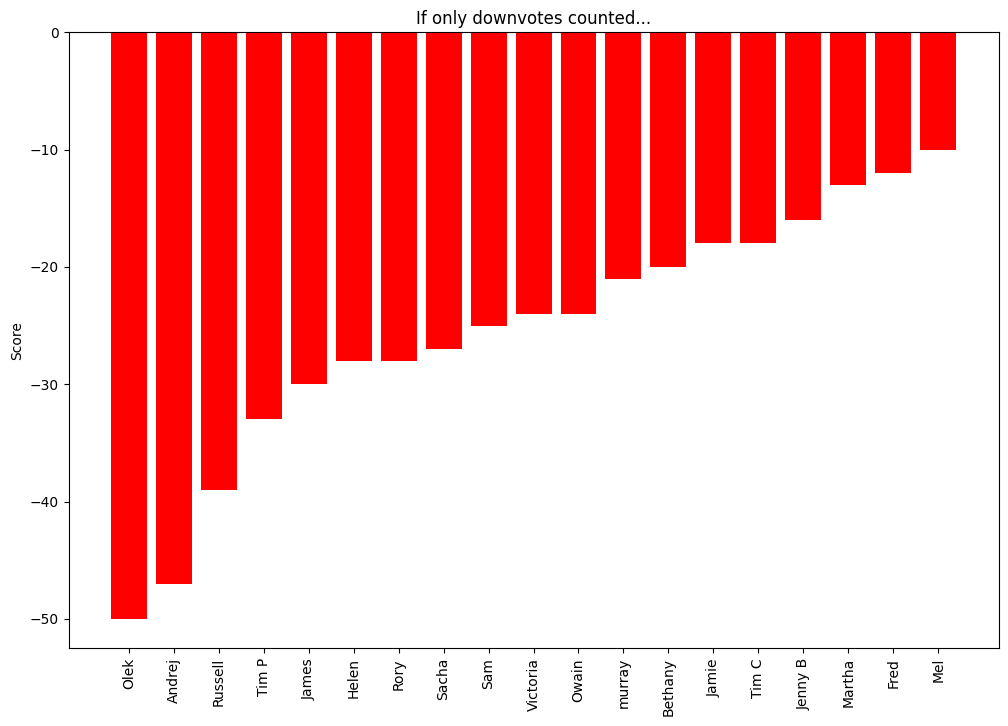

In [109]:
negative_votes = np.where(arr < 0, arr, 0)

negative_scores = np.sum(negative_votes, axis=(0, 2))

order = np.argsort(negative_scores)

fig, ax = plt.subplots(figsize=(12, 8))

ax.bar(np.arange(len(winning_order)), np.sort(negative_scores), color="red")
ax.set_xticks(range(len(winning_order)), [winning_order[i] for i in order], rotation="vertical")
ax.set_ylabel("Score")
ax.set_title("If only downvotes counted...")

plt.show()

## Controversy score

The controversy score aims to find the most controversial songs, those with the highest numbers of upvotes and downvotes leaving a score near 0

The controversy score $C$ is calculated using the following formula:


$C = \sqrt{\frac{1}{N_{\neq 0}} \sum_{i=1}^{N_{\neq 0}} (v_i - \mu)^2} \times \left( \sum_{i=1}^{n} v_i \text{ where } v_i > 0 \ - \ \alpha \sum_{i=1}^{n} v_i \text{ where } v_i < 0 \right)$


Where:
- $v_i$ are the individual votes.
- $\mu$ is the mean of the non-zero votes.
- $N_{\neq 0}$ is the number of non-zero votes.
- $\alpha$ is the ratio of positive to negative votes ($\frac{10}{3}$ in this league)
- The first part of the equation represents the standard deviation of the non-zero votes.
- The second part represents a modified range that accounts for positive and scaled negative votes.


/home/ferd/music-league-graphs/.venv/lib/python3.11/site-packages/numpy/_core/_methods.py:223: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/ferd/music-league-graphs/.venv/lib/python3.11/site-packages/numpy/_core/_methods.py:181: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/ferd/music-league-graphs/.venv/lib/python3.11/site-packages/numpy/_core/_methods.py:215: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


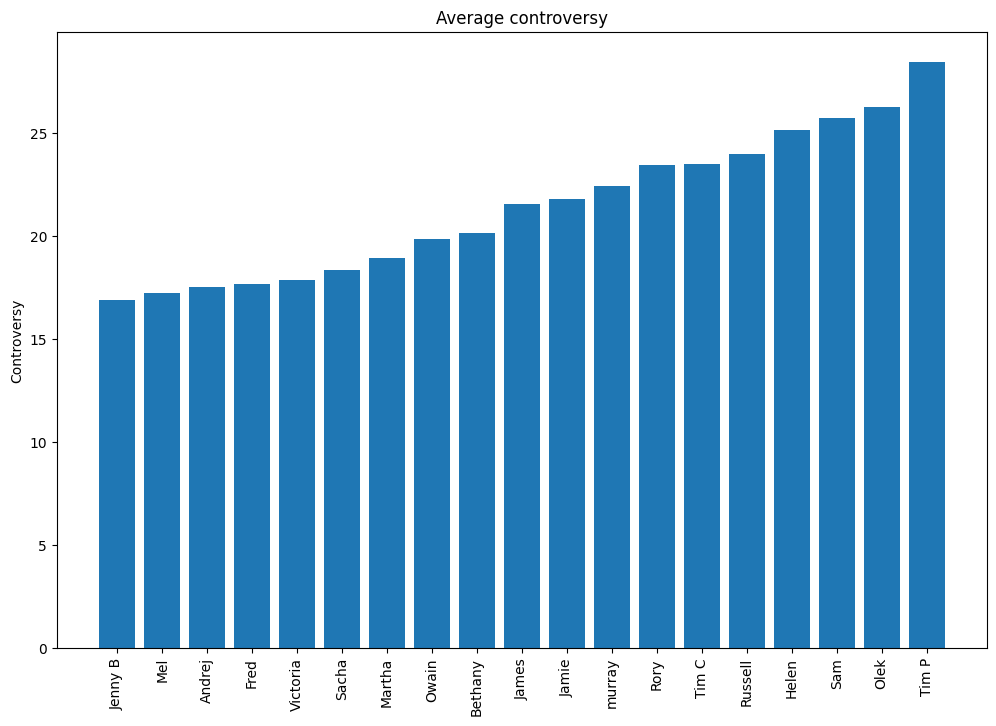

In [110]:
def controversy(vals):
    std = np.std([i for i in vals if i])
    range = sum(i for i in vals if i > 0.0) - (sum(i for i in vals if i < 0.0) * 10/3)
    return std * range

df["controversy"] = df[names].fillna(0).apply(controversy, axis=1)
df.sort_values("controversy", ascending=False)[["submitter", "song_name", "round", "controversy"]].iloc[:10]

fig, ax = plt.subplots(figsize=(12, 8))

vals = df.groupby("submitter")["controversy"].mean().sort_values()

ax.bar(np.arange(len(vals)), vals)
ax.set_xticks(range(len(vals)), vals.index, rotation="vertical")
ax.set_ylabel("Controversy")
ax.set_title("Average controversy")

plt.show()

In [111]:
df.sort_values("controversy", ascending=False)[["controversy", "submitter", "round", "song_name"]].iloc[:10]

,controversy,submitter,round,song_name
142,87.062132,Sam,Songs to code to 👩‍💻,Screaming Man - Sound Effect
179,83.486339,Fred,Yesteryear 📅,Padam Padam
1,81.649658,Jamie,120 seconds to go ⏱,Golden Slumbers - Remastered 2009
37,71.154154,James,Cover🎪,Bohemian Rhapsody
53,71.045525,Sam,Eurovision💶👀,Bono's a Fucking Cunt
129,64.358137,Tim P,Remix 🔀,Don't Stop Me Now - With Long-Lost Guitars
56,64.125731,Russell,Eurovision💶👀,Congratulations
35,62.747823,Tim P,Cover🎪,Bellas Finals: Price Tag/Don’t You (Forget Abo...
72,62.457666,Rory,Film Soundtrack 🎞,Goochie Goochie Goo
144,57.476991,Andrej,Songs to code to 👩‍💻,4'33''


In [112]:
print("Number of explicit songs submitted")
df.groupby("submitter")["explicit"].sum().sort_values(ascending=False)

Number of explicit songs submitted


submitter
Bethany     3
Rory        3
Jamie       2
Sam         2
Mel         2
Sacha       2
Fred        1
murray      1
Jenny B     1
James       1
Helen       1
Victoria    1
Olek        1
Martha      1
Russell     1
Andrej      0
Owain       0
Tim P       0
Tim C       0
Name: explicit, dtype: int64

In [113]:
# Every explicit song
df[df["explicit"]][["submitter", "round", "song_name", "artist_names"]]

,submitter,round,song_name,artist_names
4,Sam,120 seconds to go ⏱,Freaks to the Front,[Amyl and The Sniffers]
8,Victoria,120 seconds to go ⏱,say goodbye,[Sarcastic Sounds]
13,Helen,120 seconds to go ⏱,BIZCOCHITO,[ROSALÍA]
16,Bethany,120 seconds to go ⏱,Degradation,[Gorilla Biscuits]
20,Bethany,Cover🎪,Killing Me Softly With His Song,"[Fugees, Ms. Lauryn Hill]"
27,murray,Cover🎪,War Pigs,[T-Pain]
33,Olek,Cover🎪,Creep,[Scala & Kolacny Brothers]
43,Fred,Eurovision💶👀,Dancing Lasha Tumbai,[Verka Serduchka]
53,Sam,Eurovision💶👀,Bono's a Fucking Cunt,[Pizzatramp]
57,Jamie,Film Soundtrack 🎞,Lose Yourself,[Eminem]
